# Extracción e Coeficientes con la Transformada de Wavelet

Los resultados de la prueba ADF que indican que la serie temporal no es estacionaria pueden ser un indicio favorable para el uso de la **transformada wavelet**.

La transformada wavelet es una técnica que se utiliza para descomponer una señal en diferentes escalas de tiempo. Esto es especialmente útil para analizar series temporales no estacionarias, ya que permite identificar patrones y características que varían en diferentes escalas de tiempo.

**Ventajas de la transformada wavelet para series no estacionarias:**

- Captura de patrones complejos: La transformada wavelet puede capturar patrones complejos y no lineales que no son visibles en el dominio del tiempo o la frecuencia.
- Análisis multirresolución: Permite analizar la serie temporal en diferentes escalas de tiempo, lo que facilita la identificación de características que varían en el corto, mediano y largo plazo.
- Manejo de no estacionariedad: La transformada wavelet puede manejar series no estacionarias sin necesidad de transformarlas previamente en estacionarias.

## Imports y bibliotecas

In [1]:
#pip freeze > requirements.txt
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import altair as alt
import datetime
import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pywt
import random
import requests
import time
from IPython.display import clear_output, display
from statsmodels.tsa.stattools import adfuller

In [3]:
alt.data_transformers.enable("vegafusion")

# Crea la carpeta 'imgs' si no existe
if not os.path.exists('./imgs'):
    os.makedirs('./imgs')

# Crea la carpeta 'charts' si no existe
if not os.path.exists('./charts'):
    os.makedirs('./charts')

### Carga de los Datos

In [4]:
# Carga el archivo CSV en un DataFrame
df = pd.read_csv('./data/datos_PEPEUSDT_CLEAN.csv')


# Convierte `Open time_date` a datetime (Pandas debería inferir el formato ISO 8601)
df["Open time_date"] = pd.to_datetime(df["Open time_date"])

# Convierte `Close time_date` a datetime (Pandas debería inferir el formato ISO 8601)
df["Close time_date"] = pd.to_datetime(df["Close time_date"])

# Muestra los primeros 5 valores de `Close time_date`
print("\nPrimeros 5 valores de Close time_date:")
display(df["Close time_date"].head())

# Muestra los últimos 5 valores de `Close time_date`
print("\nÚltimos 5 valores de Close time_date:")
display(df["Close time_date"].tail())


Primeros 5 valores de Close time_date:


0   2023-05-05 19:59:59.999
1   2023-05-05 20:59:59.999
2   2023-05-05 21:59:59.999
3   2023-05-05 22:59:59.999
4   2023-05-05 23:59:59.999
Name: Close time_date, dtype: datetime64[ns]


Últimos 5 valores de Close time_date:


15100   2025-01-23 23:59:59.999
15101   2025-01-24 00:59:59.999
15102   2025-01-24 01:59:59.999
15103   2025-01-24 02:59:59.999
15104   2025-01-24 03:59:59.999
Name: Close time_date, dtype: datetime64[ns]

In [5]:
### Carga de los Datos
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Lee el archivo CSV en un dataframe
df = pd.read_csv('./data/datos_PEPEUSDT_CLEAN.csv')

# Convierte `Open time_date` a datetime
df["Open time_date"] = pd.to_datetime(df["Open time_date"], format='%Y-%m-%d %H:%M:%S')

# Convierte `Close time_date` a datetime
df["Close time_date"] = pd.to_datetime(df["Close time_date"], format='%Y-%m-%d %H:%M:%S.%f')

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15105 entries, 0 to 15104
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Open time_date                15105 non-null  datetime64[ns]
 1   Close time_date               15105 non-null  datetime64[ns]
 2   Open                          15105 non-null  float64       
 3   High                          15105 non-null  float64       
 4   Low                           15105 non-null  float64       
 5   Close                         15105 non-null  float64       
 6   Variation                     15105 non-null  float64       
 7   Volume                        15105 non-null  float64       
 8   Quote asset volume            15105 non-null  float64       
 9   Number of trades              15105 non-null  int64         
 10  Taker buy base asset volume   15105 non-null  float64       
 11  Taker buy quote asset volume

## Visualización serie de tiempo


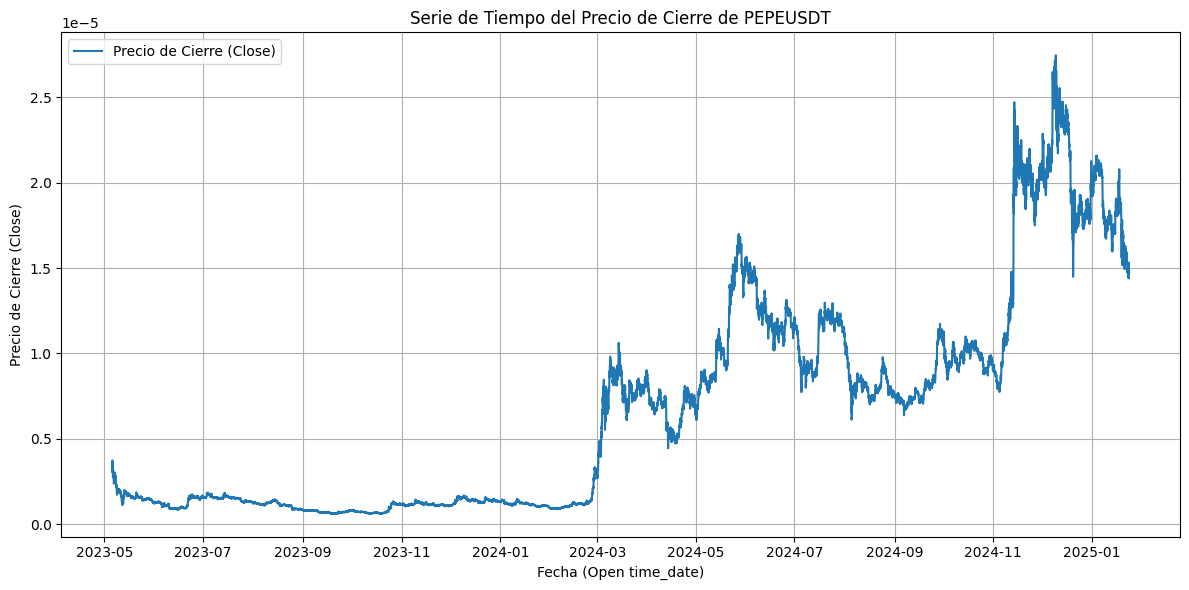

In [6]:
plt.figure(figsize=(12, 6)) # Ajusta el tamaño de la figura según sea necesario
plt.plot(df['Open time_date'], df['Close'], label='Precio de Cierre (Close)')
plt.title('Serie de Tiempo del Precio de Cierre de PEPEUSDT')
plt.xlabel('Fecha (Open time_date)')
plt.ylabel('Precio de Cierre (Close)')
plt.grid(True) # Añade una cuadrícula para mejor visualización
plt.legend() # Muestra la leyenda
plt.tight_layout() # Ajusta el diseño para evitar que las etiquetas se superpongan
plt.show()


## Experimentación Transformada Wavelet

Para la experimentación con la transformada wavelet, se ha seleccionado la wavelet **`sym4`** (Symlet de orden 4) como wavelet base para la descomposición. Si bien existen diversas familias de wavelets disponibles, la elección de `sym4` se justifica por las siguientes razones, especialmente relevantes para el análisis de series temporales financieras como los precios de acciones:

*   **Simetría:** A diferencia de las wavelets Daubechies (`db`), las wavelets Symlet (`sym`) son diseñadas para ser **casi simétricas**. Esta propiedad es crucial en el análisis de series temporales, ya que la simetría minimiza la **distorsión de fase** en la señal reconstruida.  En el contexto de precios de acciones, donde la **temporalidad y la secuencia de eventos son importantes**, reducir la distorsión de fase ayuda a preservar la integridad de las características temporales de la serie. Las wavelets `db`, al ser asimétricas, pueden introducir mayores desplazamientos de fase.

*   **Compacidad y Soporte Compacto:** Tanto las wavelets `sym` como `db` poseen **soporte compacto**, lo que significa que están localizadas tanto en el tiempo como en la frecuencia. Esto es beneficioso para la eficiencia computacional y para la detección de características locales en la serie temporal.  `sym4` ofrece un buen compromiso entre compacidad y otras propiedades deseables.

*   **Número de Momentos Desvanecientes:** `sym4` (y `db4`) tienen 4 momentos desvanecientes. Un mayor número de momentos desvanecientes permite a la wavelet representar polinomios de mayor grado, lo que puede ser útil para capturar **tendencias y comportamientos suaves** en los precios de las acciones. Si bien `db4` también tiene 4 momentos desvanecientes, la asimetría de `db4` la hace menos preferible en comparación con `sym4` para series temporales.

*   **Suavidad:** Las wavelets Symlet, incluyendo `sym4`, son generalmente **más suaves** que las wavelets Daubechies de orden similar. Esta suavidad puede ser ventajosa para analizar señales complejas y ruidosas como las series de precios de acciones, ayudando a **filtrar el ruido de alta frecuencia** y resaltar patrones subyacentes.

*   **Adecuación sobre `db1` (Haar):**  Si bien `db1` (wavelet de Haar) es la wavelet Daubechies más simple y computacionalmente eficiente, su **falta de continuidad y baja regularidad** la hacen menos adecuada para el análisis detallado de series temporales financieras.  `db1` tiene una resolución frecuencial limitada y puede ser demasiado sensible al ruido. `sym4` ofrece una mejora significativa en términos de suavidad y características frecuenciales en comparación con `db1`.

En resumen, la wavelet `sym4` se elige por su **equilibrio entre simetría, compacidad, momentos desvanecientes y suavidad**, lo que la convierte en una opción robusta y adecuada para la descomposición y análisis de series temporales de precios de acciones, buscando capturar patrones relevantes minimizando la distorsión introducida por la transformada. Si bien otras wavelets podrían ser exploradas, `sym4` representa un buen punto de partida y una opción comúnmente utilizada en aplicaciones de procesamiento de señales y análisis de series temporales.


### Determinar niveles de descomposición
Se requiere determinar los niveles de descomposición para 
- Hora
- Dia
- Semana

Los datos vienen ya en horas.

In [7]:
# Calcula la duración en horas (contando el número de registros)
duracion_horas = len(df)

# Calcula los niveles de descomposición
niveles_dias = int(np.round(np.log2(duracion_horas / 24)))
niveles_meses = int(np.round(np.log2(duracion_horas / (24 * 30))))

print(f"Niveles de descomposición para días: {niveles_dias}")
print(f"Niveles de descomposición para meses: {niveles_meses}")

Niveles de descomposición para días: 9
Niveles de descomposición para meses: 4


### Cálculo de coeficienes por medio de la transformada Wavelet

En el contexto de la Transformada Wavelet Discreta (DWT), la descomposición de una señal temporal resulta en dos conjuntos de coeficientes fundamentales en cada nivel de resolución: los **coeficientes de aproximación (cA)** y los **coeficientes de detalle (cD)**. Estos componentes son esenciales para el análisis multirresolución y la caracterización de la señal en diferentes escalas temporales y frecuenciales.

En el contexto de la descomposición wavelet, es fundamental comprender la relación entre los **coeficientes de aproximación (cA)** y los **coeficientes de detalle (cD)** con respecto a la serie temporal original.  

Los **coeficientes de aproximación (cA)**, visualizados gráficamente, representan una **versión suavizada** de la serie temporal.  Estos coeficientes encapsulan la **tendencia subyacente** y el comportamiento general de la señal en una escala de tiempo más amplia, filtrando las fluctuaciones de alta frecuencia.  

En contraste, los **coeficientes de detalle (cD)** revelan los **"deltas" o cambios** presentes en la serie temporal.  Cada nivel de detalle captura las **fluctuaciones y variaciones** con respecto a la tendencia suavizada, representando la información que se ha sustraído al obtener la aproximación.  

De esta manera, mientras que la gráfica de los coeficientes de aproximación exhibe un comportamiento suavizado que refleja la evolución general de la serie, las gráficas de los coeficientes de detalle ponen de manifiesto las **magnitudes y direcciones de los cambios** o desviaciones con respecto a dicha tendencia, en diferentes escalas de tiempo correspondientes a cada nivel de detalle.  

En conjunto, ambos tipos de coeficientes ofrecen una representación completa y multirresolución de la serie temporal original, permitiendo analizar tanto su comportamiento global como sus variaciones locales.

In [8]:
# Señal del precio de cierre
signal = df['Close'].values

# Definir el wavelet y el nivel de descomposición
#wavelet = 'db4'  # Wavelet de Daubechies 4
wavelet = 'sym4'  
level = 9  # Nivel de descomposición hasta dias

# Aplicar la transformada wavelet discreta (DWT)
coeffs = pywt.wavedec(signal, wavelet, level=level)

### Coeficientes de Aproximación (cA)

Los **coeficientes de aproximación (cA)** representan la componente de **baja frecuencia** de la señal original.  Formalmente, estos coeficientes son el resultado de la convolución de la señal con un filtro de paso bajo, seguido de un submuestreo.  En la práctica, los coeficientes de aproximación capturan la **tendencia general** y las **características de baja resolución** de la serie temporal, proporcionando una representación suavizada de la señal original.

*   **Interpretación Técnica:** Los cA encapsulan la información de la señal que varía lentamente en el tiempo, reflejando las **componentes de frecuencia más bajas**.  En el análisis de series temporales financieras, estos coeficientes pueden ser indicativos de **tendencias a largo plazo**, **ciclos de baja frecuencia**, o la **estructura fundamental** del movimiento del precio.

*   **Escala de Representación:** En una descomposición multinivel, los coeficientes de aproximación en niveles sucesivos (cA<sub>1</sub>, cA<sub>2</sub>, cA<sub>3</sub>, ...) representan la señal en escalas temporales progresivamente más **gruesas** o **coarsas**.  Cada nivel de aproximación subsiguiente ofrece una visión más generalizada de la señal, filtrando componentes de frecuencia más elevadas.


#### Visualización de los Coeficientes de Aproximación

In [9]:
def calculate_approx_weeks(coefficient_index, decomposition_level):
    """Calculates approximate weeks represented by a wavelet coefficient index at a given decomposition level.

    Args:
        coefficient_index (int): The index of the wavelet coefficient (0-based).
        decomposition_level (int): The level of wavelet decomposition.

    Returns:
        int: Approximate number of weeks represented by the coefficient index.
    """
    hours_per_coefficient = 2**decomposition_level
    weeks_per_coefficient = hours_per_coefficient / (24 * 7)
    approx_weeks = int(np.round((coefficient_index + 1) * weeks_per_coefficient)) # +1 because coefficient_index is 0-based
    return approx_weeks


In [10]:

def plot_approximation_with_weeks(coeffs, decomposition_level=9, tick_step=5, figsize=(10, 5)):
    """
    Plots the wavelet approximation coefficients with a dual x-axis showing approximate weeks.

    Args:
        coeffs (list): List of wavelet coefficients from pywt.wavedec. coeffs[0] is approximation (cA).
        decomposition_level (int): The level of wavelet decomposition used. Default is 9.
        tick_step (int): Step for displaying ticks on the x-axes. Default is 5.
        figsize (tuple): Figure size for the plot. Default is (10, 5).
    """
    approx_coefficients = coeffs[0]
    num_coeficientes_aprox = len(approx_coefficients)
    principal_xticks = np.arange(0, num_coeficientes_aprox, step=tick_step)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(approx_coefficients)
    ax.set_title('Aproximación (cA)')
    ax.set_xlabel('Índice de Coeficientes (cA)') # Label for the primary x-axis


    # Create secondary x-axis on top for approximate weeks
    ax2 = ax.secondary_xaxis('top')
    week_labels_secondary = [str(calculate_approx_weeks(i, decomposition_level)) for i in principal_xticks]

    ax2.set_xticks(principal_xticks)
    ax2.set_xticklabels(week_labels_secondary)
    ax2.set_xlabel('Semanas aprox.')

    plt.tight_layout()
    plt.show()

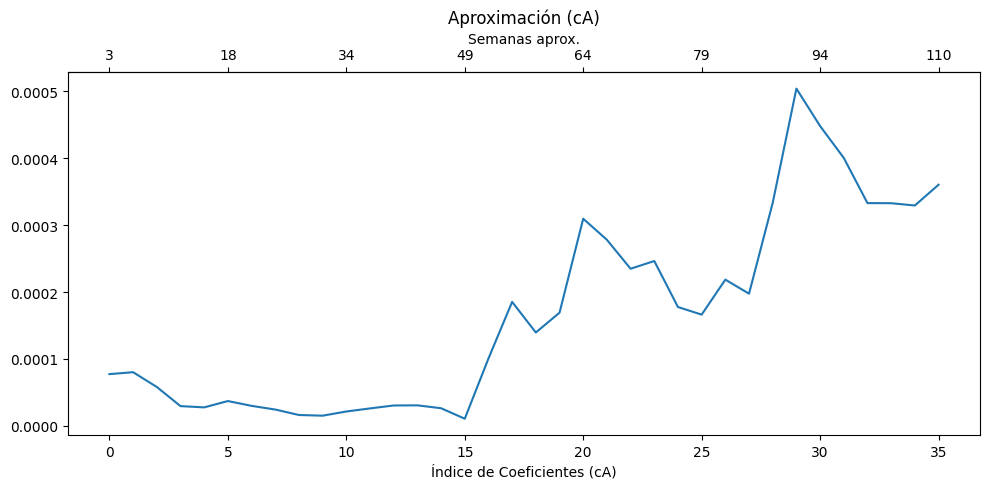

In [11]:
# plot_approximation_with_weeks(coeffs) # Using default level=9 and tick_step=5
plot_approximation_with_weeks(coeffs, decomposition_level=9, tick_step=5) # Explicitly calling with level and step

### Coeficientes de Detalle (cD)

En contraste, los **coeficientes de detalle (cD)** representan la componente de **alta frecuencia** de la señal.  Se obtienen mediante la convolución de la señal con un filtro de paso alto, también seguido de un submuestreo.  Los coeficientes de detalle son sensibles a las **variaciones rápidas**, los **bordes**, y las **fluctuaciones de alta frecuencia** presentes en la serie temporal.

*   **Interpretación Técnica:** Los cD contienen información sobre los **detalles finos** y las **componentes de frecuencia más altas** de la señal.  En el contexto de series temporales financieras, estos coeficientes pueden reflejar la **volatilidad a corto plazo**, **ruido de alta frecuencia**, **discontinuidades**, o **eventos transitorios** que generan cambios abruptos en la señal.

*   **Escala de Representación:**  Similarmente a los coeficientes de aproximación, los coeficientes de detalle en diferentes niveles (cD<sub>1</sub>, cD<sub>2</sub>, cD<sub>3</sub>, ...) corresponden a diferentes escalas temporales.  Sin embargo, en el caso de los detalles, cD<sub>1</sub> representa los detalles más **finos** (mayor frecuencia), mientras que los niveles de detalle superiores (cD<sub>2</sub>, cD<sub>3</sub>, ...) capturan detalles en escalas progresivamente más **gruesas**, aunque siempre en el dominio de las altas frecuencias relativas a la señal de aproximación del mismo nivel.


#### Visualización de los Coeficientes de Detalle

In [12]:
def _setup_subplots(decomposition_level, figsize):
    """Sets up the figure and axes for detail coefficient plots."""
    fig, axes = plt.subplots(nrows=decomposition_level, ncols=1, figsize=figsize)
    return fig, axes.flatten()

def _plot_detail_level(ax, detail_coeffs, wavelet_name, correct_level_number, line_color, line_width):
    """Plots the detail coefficients for a single level."""
    level_name = f'cD{correct_level_number}'
    ax.plot(detail_coeffs, color=line_color, linewidth=line_width)
    ax.set_title(f'({level_name}) - Wavelet: {wavelet_name}, Nivel: {correct_level_number}')
    ax.set_xlabel('Índice de Coeficientes')
    ax.set_ylabel('Amplitud')

In [13]:
def _setup_secondary_xaxis(ax, correct_level_number, detail_coeffs, hours_values):
    """Sets up the secondary x-axis for time duration."""
    ax2 = ax.secondary_xaxis('top')
    time_labels_secondary = []
    hours_per_coef = hours_values[correct_level_number]
    days_per_coef = hours_per_coef / 24
    weeks_per_coef = days_per_coef / 7 # Calculate weeks per coefficient

    top_axis_step = max(5, len(detail_coeffs) // 10) if correct_level_number <= 7 else 5
    coeficientes_ticks_secundarios = np.arange(0, len(detail_coeffs), step=top_axis_step)

    for i in coeficientes_ticks_secundarios:
        if correct_level_number <= 4: # Use hours for levels 1-4
            time_labels_secondary.append(str(int(np.round((i+1) * hours_per_coef))))
            time_unit_label = "Horas aprox."
        elif correct_level_number <= 6: # Use days for levels 5-6
             time_labels_secondary.append(str(np.round((i+1) * days_per_coef, 1)))
             time_unit_label = "Días aprox."
        elif correct_level_number <= 7: # Use days for level 7
            time_labels_secondary.append(str(np.round((i+1) * days_per_coef, 0)))
            time_unit_label = "Días aprox."
        else: # Use weeks for levels 8-9 - MODIFIED
            time_labels_secondary.append(str(np.round((i+1) * weeks_per_coef, 1))) # 1 decimal place for weeks
            time_unit_label = "Semanas aprox." # Changed unit label to "Semanas aprox."

    ax2.set_xticks(coeficientes_ticks_secundarios)
    ax2.set_xticklabels(time_labels_secondary)
    ax2.set_xlabel(time_unit_label)

In [14]:

def plot_detail_coefficients(coeffs, wavelet_name, decomposition_level, figsize=(10, 20)):
    """
    Modular and decoupled function to plot detail coefficients (cD1 to cDlevel) in a single figure.

    Args:
        coeffs (list): Wavelet coefficients from pywt.wavedec.
        wavelet_name (str): Wavelet name used for decomposition.
        decomposition_level (int): Decomposition level.
        figsize (tuple): Figure size for the consolidated plot.
    """
    hours_values = { # Numerical hours for calculation
        1: 2, 2: 4, 3: 8, 4: 16,
        5: 32, 6: 64, 7: 128, 8: 256,
        9: 512
    }

    fig, axes = _setup_subplots(decomposition_level, figsize)

    # Get a list of distinct colors for plotting lines
    available_colors = list(mcolors.TABLEAU_COLORS.keys())
    random.shuffle(available_colors)

    for level_index in range(1, decomposition_level + 1):
        detail_coeffs = coeffs[level_index]
        correct_level_number = decomposition_level - level_index + 1
        ax = axes[level_index-1]

        # Determine linewidth based on detail level - MODIFIED
        if correct_level_number <= 3:
            line_width = 0.15  # Thinner linewidth for cD1 to cD3
        elif correct_level_number <= 5:
            line_width = 0.5   # Medium linewidth for cD4 and cD5
        else:
            line_width = 1.0   # Default linewidth for cD6 to cD9
            
        line_color = available_colors[level_index - 1 % len(available_colors)]

        _plot_detail_level(ax, detail_coeffs, wavelet_name, correct_level_number, line_color, line_width)
        _setup_secondary_xaxis(ax, correct_level_number, detail_coeffs, hours_values)


    plt.tight_layout()
    plt.show()

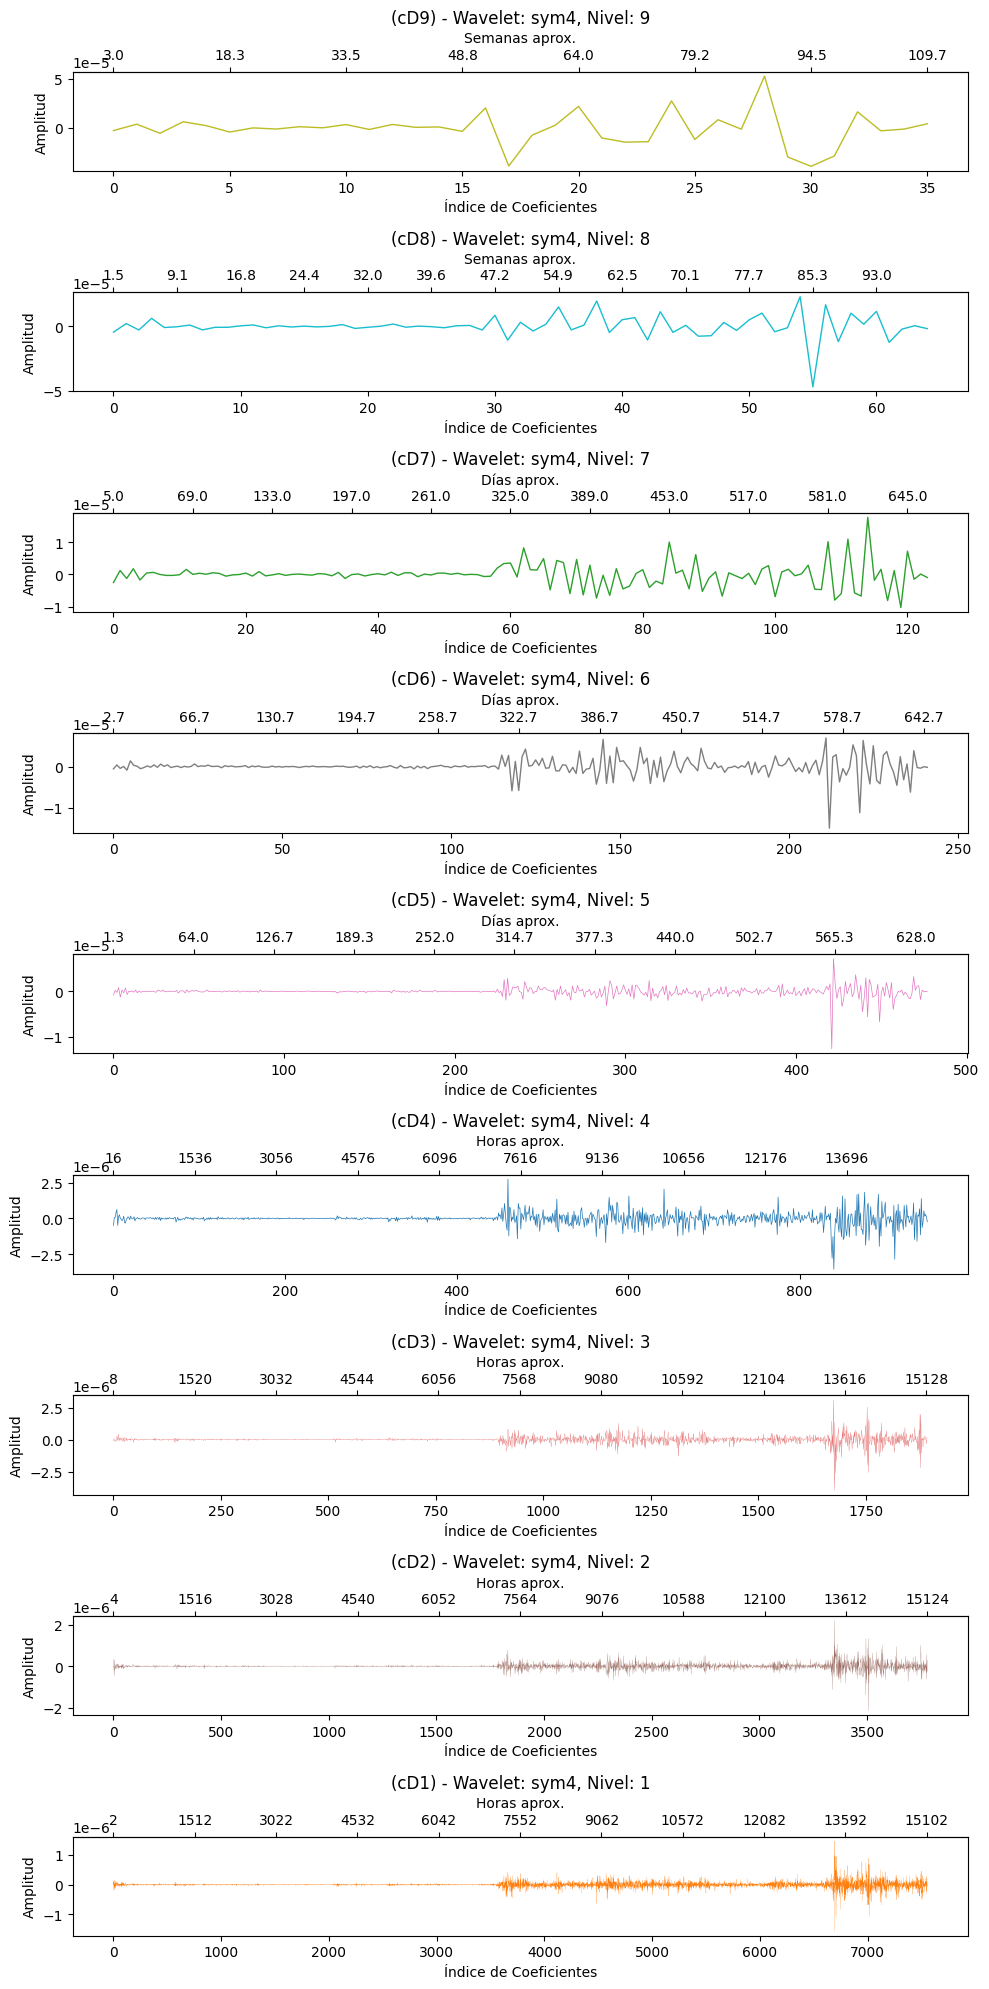

In [15]:
plot_detail_coefficients(coeffs, wavelet, level)

### Coeficientes de Detalle (cD)

En contraste, los **coeficientes de detalle (cD)** representan la componente de **alta frecuencia** de la señal.  Se obtienen mediante la convolución de la señal con un filtro de paso alto, también seguido de un submuestreo.  Los coeficientes de detalle son sensibles a las **variaciones rápidas**, los **bordes**, y las **fluctuaciones de alta frecuencia** presentes en la serie temporal.

*   **Interpretación Técnica:** Los cD contienen información sobre los **detalles finos** y las **componentes de frecuencia más altas** de la señal.  En el contexto de series temporales financieras, estos coeficientes pueden reflejar la **volatilidad a corto plazo**, **ruido de alta frecuencia**, **discontinuidades**, o **eventos transitorios** que generan cambios abruptos en la señal.

*   **Escala de Representación:**  Similarmente a los coeficientes de aproximación, los coeficientes de detalle en diferentes niveles (cD<sub>1</sub>, cD<sub>2</sub>, cD<sub>3</sub>, ...) corresponden a diferentes escalas temporales.  Sin embargo, en el caso de los detalles, cD<sub>1</sub> representa los detalles más **finos** (mayor frecuencia), mientras que los niveles de detalle superiores (cD<sub>2</sub>, cD<sub>3</sub>, ...) capturan detalles en escalas progresivamente más **gruesas**, aunque siempre en el dominio de las altas frecuencias relativas a la señal de aproximación del mismo nivel.


#### Exportar Los Coeficientes

In [16]:
def save_wavelet_coefficients(coeffs, filepath):
    """
    Saves wavelet coefficients to a compressed NPZ file.

    Args:
        coeffs (list or array-like): Wavelet coefficients (e.g., from pywt.wavedec).  Can be a list or tuple of arrays.
        filepath (str): The full filepath (including path and filename) where the coefficients should be saved.  
                        Should end with '.npz'.  If not the '.npz' extension will be appended.


    Raises:
        ValueError: If the filepath doesn't end in '.npz' after handling and if coeffs isn't a list, tuple or numpy array
    """
    if not isinstance(coeffs, (list, tuple, np.ndarray)):
        raise ValueError("coeffs must be a list, tuple, or NumPy array.")


    file_path_npz = filepath if filepath.endswith(".npz") else f"{filepath}.npz"
    if not file_path_npz.endswith('.npz'):
        raise ValueError("filepath must end with '.npz'")

    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path_npz), exist_ok=True)

    if isinstance(coeffs, np.ndarray): # Save single numpy array
        np.savez_compressed(file_path_npz, coeffs=coeffs)
    elif isinstance(coeffs, (list, tuple)): # Iterate to save list/tuple of arrays with labels 'a', 'd1', 'd2', ...
        coeff_dict = {}
        coeff_dict['a'] = coeffs[0]  # Approximation coefficients
        for i, detail_coeff in enumerate(coeffs[1:]):  # Detail coefficients
            coeff_dict[f'd{i+1}'] = detail_coeff
        np.savez_compressed(file_path_npz, **coeff_dict)

In [17]:
output_dir = "./coeffs/"
os.makedirs(output_dir, exist_ok=True) # creates the output directory if it doesn't already exist.
# Path to save list/tuple of numpy arrays
file_path = os.path.join(output_dir, "coeff.npz")

save_wavelet_coefficients(coeffs, file_path)

In [18]:
import numpy as np
import os

def load_wavelet_coefficients(filepath):
    """Loads wavelet coefficients from a compressed NPZ file.

    Args:
        filepath (str): The full filepath to the .npz file containing the wavelet coefficients.

    Returns:
        tuple or numpy.ndarray: If the NPZ file contains multiple arrays (like 'a', 'd1', 'd2', etc.), the function returns a tuple
                              of NumPy arrays in the order: (approximation_coeffs, detail_coeffs_level_1, detail_coeffs_level_2, ...).
                              If the NPZ file contains a single array named 'coeffs', that array is returned directly.
                              Returns None if an error occurs during file loading.


    Raises:
        FileNotFoundError: If the provided filepath doesn't exist.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    try:
        with np.load(filepath) as data:
            if 'coeffs' in data:  # Check for a single array named 'coeffs'
                return data['coeffs']  # Return the single array
            else:  # Handle multiple arrays (approximation and details)
                coeffs = []
                coeffs.append(data['a'])  # Approximation coefficients
                level = 1
                while f'd{level}' in data:
                    coeffs.append(data[f'd{level}'])
                    level += 1
                return tuple(coeffs)

    except Exception as e:  # Catch any exceptions during file loading
        print(f"Error loading wavelet coefficients from {filepath}: {e}")
        return None  # Return None to indicate failure

In [19]:
loaded_coeffs_list = load_wavelet_coefficients(file_path)

if loaded_coeffs_list is not None:
    cA, cD1, cD2 , cD3 , cD4 , cD5 , cD6 , cD7 , cD8 , cD9 = loaded_coeffs_list  # Unpack as needed based on your decomposition level
    print("Loaded coeffs from list style file:", len(loaded_coeffs_list), "elements")
else:
    print("Failed to load list style coeffs file.")



Loaded coeffs from list style file: 10 elements


### Análisis Multirresolución y Reconstrucción

La DWT, a través de los coeficientes cA y cD, proporciona un marco para el **análisis multirresolución** de la señal.  La descomposición permite examinar la serie temporal en **múltiples escalas de tiempo y frecuencia**, facilitando la identificación de patrones y características que podrían no ser evidentes en el dominio temporal original.  Es fundamental destacar que la **reconstrucción perfecta** de la señal original es posible a partir de la combinación de todos los coeficientes de aproximación y detalle, demostrando que la DWT preserva la información completa de la señal, distribuyéndola en diferentes componentes frecuenciales y escalares.

Este enfoque multirresolución es ventajoso para:

*   **Identificación de patrones multi-escala:**  Discernir tendencias de largo plazo (en cA de niveles superiores) y fluctuaciones de corto plazo (en cD de niveles inferiores).
*   **Filtrado de ruido:**  Atenuar o eliminar selectivamente coeficientes de detalle para reducir el ruido de alta frecuencia.
*   **Compresión de datos:**  Representar la señal de forma eficiente mediante la selección de coeficientes relevantes y la omisión de aquellos con menor información significativa.

Los coeficientes de aproximación y detalle constituyen los bloques constructivos de la representación wavelet de una señal, permitiendo un análisis detallado y versátil en el dominio tiempo-frecuencia, con aplicaciones significativas en el procesamiento de señales y el análisis de series temporales.
